# Predicción del Precio de Acciones con Redes Neuronales LSTM

**Objetivo del Proyecto:**
Este proyecto utiliza una red neuronal recurrente (RNN), específicamente una arquitectura de Memoria a Corto y Largo Plazo (LSTM), para predecir el precio de cierre de las acciones de TATA (NSE).

El análisis sigue estos pasos:
1.  **Carga y Preparación:** Importar los datos históricos.
2.  **Preprocesamiento:** Limpiar, formatear fechas y escalar los datos.
3.  **Creación de Secuencias:** Transformar los datos en "ventanas temporales" (ej. usar 60 días para predecir el día 61).
4.  **Modelado:** Construir, entrenar y compilar un modelo LSTM con Keras.
5.  **Evaluación:** Realizar predicciones sobre el conjunto de validación y evaluar su precisión.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error

%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

## 1. Carga y Exploración de Datos

Cargamos el archivo CSV y realizamos una primera inspección. También convertimos la columna de fecha a un objeto `datetime` de Pandas y la establecemos como el índice del DataFrame. Esto es fundamental para trabajar con series temporales.

In [13]:
ruta_archivo = "NSE-TATA.csv"
datos = pd.read_csv(ruta_archivo)

print("Datos cargados:")
print(datos.head())
print("\nInformación del DataFrame:")
datos.info()
datos["Date"] = pd.to_datetime(datos.Date, format="%Y-%m-%d")
datos.index = datos['Date']
datos = datos.sort_index(ascending=True, axis=0)

print("\nDatos con índice de fecha:")
print(datos.head())

Datos cargados:
         Date    Open    High     Low    Last   Close  Total Trade Quantity  \
0  2018-10-08  208.00  222.25  206.85  216.00  215.15             4642146.0   
1  2018-10-05  217.00  218.60  205.90  210.25  209.20             3519515.0   
2  2018-10-04  223.50  227.80  216.15  217.25  218.20             1728786.0   
3  2018-10-03  230.00  237.50  225.75  226.45  227.60             1708590.0   
4  2018-10-01  234.55  234.60  221.05  230.30  230.90             1534749.0   

   Turnover (Lacs)  
0         10062.83  
1          7407.06  
2          3815.79  
3          3960.27  
4          3486.05  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1235 non-null   object 
 1   Open                  1235 non-null   float64
 2   High                  1235 non-null   fl

## 2. Visualización Inicial

Graficamos el histórico del precio de cierre ('Close') para entender visualmente la tendencia y la volatilidad de los datos con los que vamos a trabajar.

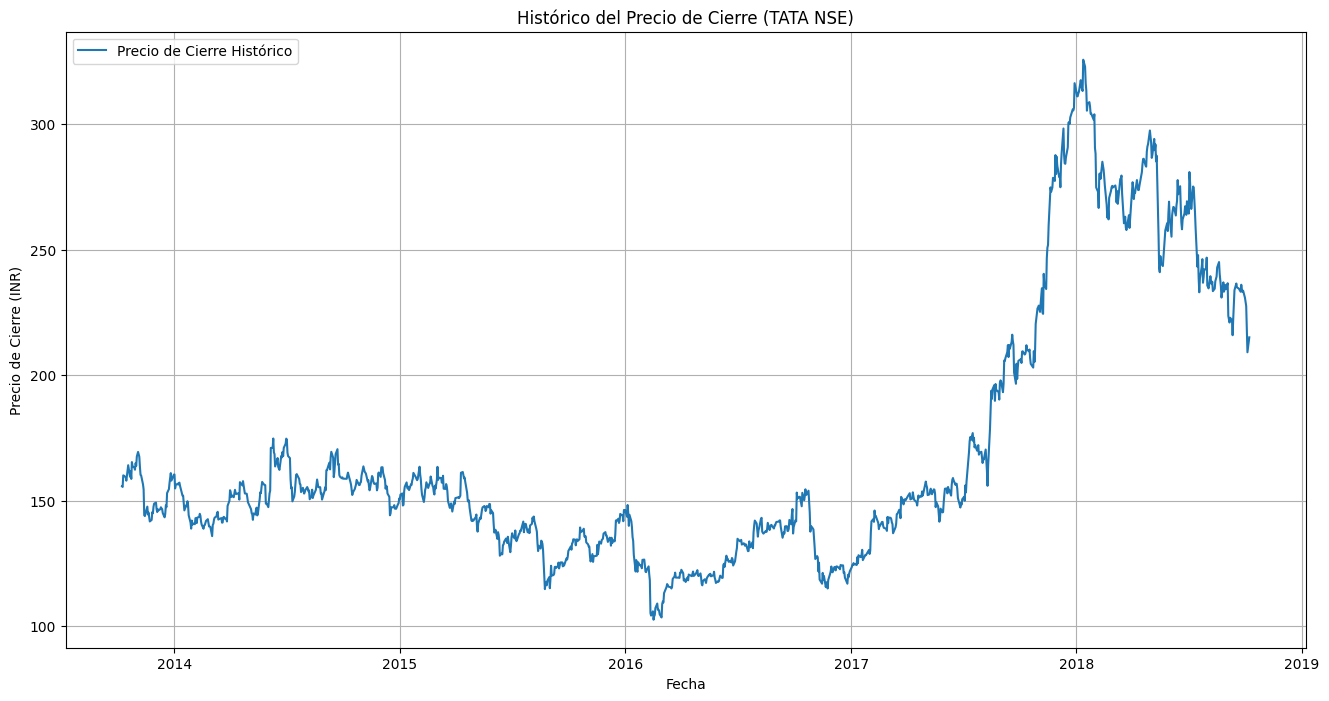

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(datos["Close"], label='Precio de Cierre Histórico')
plt.title('Histórico del Precio de Cierre (TATA NSE)')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (INR)')
plt.legend()
plt.grid(True)
plt.show()

## 3. Preprocesamiento para LSTM

Los modelos LSTM requieren una preparación de datos específica:

1.  **Filtrado:** Solo nos interesa la columna 'Close' para este modelo.
2.  **División:** Separamos los datos en conjuntos de **entrenamiento** (train) y **validación** (test/validation). Hacemos 80/20 %.
3.  **Escalado:** Las redes neuronales funcionan mejor con datos normalizados. Usaremos `MinMaxScaler` para escalar los precios entre 0 y 1.


In [15]:
datos_cierre = datos.filter(['Close'])

conjunto_datos = datos_cierre.values

longitud_entrenamiento = 987 
print(f"Total de datos: {len(conjunto_datos)}")
print(f"Datos de entrenamiento: {longitud_entrenamiento}")
print(f"Datos de validación: {len(conjunto_datos) - longitud_entrenamiento}")


datos_entrenamiento = conjunto_datos[0:longitud_entrenamiento, :]
datos_validacion = conjunto_datos[longitud_entrenamiento:, :]

escalador = MinMaxScaler(feature_range=(0, 1))

datos_entrenamiento_escalados = escalador.fit_transform(datos_entrenamiento)

datos_validacion_escalados = escalador.transform(datos_validacion)

Total de datos: 1235
Datos de entrenamiento: 987
Datos de validación: 248


## 4. Creación de Secuencias

Ahora, creamos las secuencias de datos. El modelo LSTM aprenderá a predecir el precio en el día `t+1` basándose en los `N` días anteriores.

* `ventana_temporal` (N): Usaremos 60 días.
* `X_entrenamiento`: Será una lista de secuencias de 60 días.
* `y_entrenamiento`: Será el precio del día 61 (el que queremos predecir).

In [16]:
X_entrenamiento = []
y_entrenamiento = []
ventana_temporal = 60

for i in range(ventana_temporal, len(datos_entrenamiento_escalados)):
    X_entrenamiento.append(datos_entrenamiento_escalados[i - ventana_temporal:i, 0])
    y_entrenamiento.append(datos_entrenamiento_escalados[i, 0])

X_entrenamiento, y_entrenamiento = np.array(X_entrenamiento), np.array(y_entrenamiento)

X_entrenamiento = np.reshape(X_entrenamiento, (X_entrenamiento.shape[0], X_entrenamiento.shape[1], 1))

print(f"Forma de X_entrenamiento: {X_entrenamiento.shape}")
print(f"Forma de y_entrenamiento: {y_entrenamiento.shape}")

Forma de X_entrenamiento: (927, 60, 1)
Forma de y_entrenamiento: (927,)


## 5. Construcción del Modelo LSTM

Definimos la arquitectura de nuestra red neuronal:

* `Sequential`: Un modelo lineal de capas.
* `LSTM (units=50, return_sequences=True)`: Primera capa LSTM. `return_sequences=True` es necesario porque apilaremos otra capa LSTM encima.
* `Dropout(0.2)`: Capa de regularización para prevenir el sobreajuste, "apagando" aleatoriamente el 20% de las neuronas.
* `LSTM (units=50, return_sequences=False)`: Segunda capa LSTM. `return_sequences=False` porque es la última capa recurrente.
* `Dense(1)`: Capa de salida final, con una sola neurona que predecirá el precio escalado.

In [17]:
modelo_lstm = Sequential()

modelo_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_entrenamiento.shape[1], 1)))
modelo_lstm.add(Dropout(0.2))

modelo_lstm.add(LSTM(units=50, return_sequences=False))
modelo_lstm.add(Dropout(0.2))

modelo_lstm.add(Dense(1))

modelo_lstm.compile(loss='mean_squared_error', optimizer='adam')

modelo_lstm.summary()

c:\Users\juanr\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Entrenamiento del Modelo

Entrenamos el modelo con nuestros datos de entrenamiento (`X_entrenamiento`, `y_entrenamiento`).

In [19]:
# Entrenar el modelo
historial = modelo_lstm.fit(
    X_entrenamiento, 
    y_entrenamiento, 
    epochs=3,
    batch_size=1, 
    verbose=2
)


Epoch 1/3
927/927 - 24s - 26ms/step - loss: 0.0015
Epoch 2/3
927/927 - 27s - 29ms/step - loss: 0.0017
Epoch 3/3
927/927 - 24s - 25ms/step - loss: 0.0015


## 7. Generación de Predicciones

Para probar el modelo, debemos crear el conjunto de prueba (`X_prueba`) de la misma manera que creamos el de entrenamiento.

Un punto clave es que para predecir el primer valor de validación, necesitamos los últimos 60 días del conjunto de entrenamiento. Por lo tanto, combinamos los datos de entrenamiento y validación para construir las secuencias de prueba.

In [20]:
total_datos = datos_cierre.values
entradas = total_datos[len(total_datos) - len(datos_validacion) - ventana_temporal:]

entradas = entradas.reshape(-1, 1)
entradas_escaladas = escalador.transform(entradas)

X_prueba = []
for i in range(ventana_temporal, len(entradas_escaladas)):
    X_prueba.append(entradas_escaladas[i - ventana_temporal:i, 0])

X_prueba = np.array(X_prueba)
X_prueba = np.reshape(X_prueba, (X_prueba.shape[0], X_prueba.shape[1], 1))

print(f"Forma de X_prueba: {X_prueba.shape}")

Forma de X_prueba: (248, 60, 1)


## 8. Evaluación y Visualización de Resultados

Ahora, usamos el modelo entrenado para predecir los valores de `X_prueba`. Las predicciones resultantes estarán escaladas (entre 0 y 1), por lo que debemos usar `escalador.inverse_transform()` para revertirlas a su valor original en INR.

Finalmente, graficamos las predicciones junto con los datos reales para evaluar visualmente el rendimiento del modelo.

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Root Mean Squared Error (RMSE): 10.51 INR


C:\Users\juanr\AppData\Local\Temp\ipykernel_16096\1114185985.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validacion['Predicciones'] = predicciones


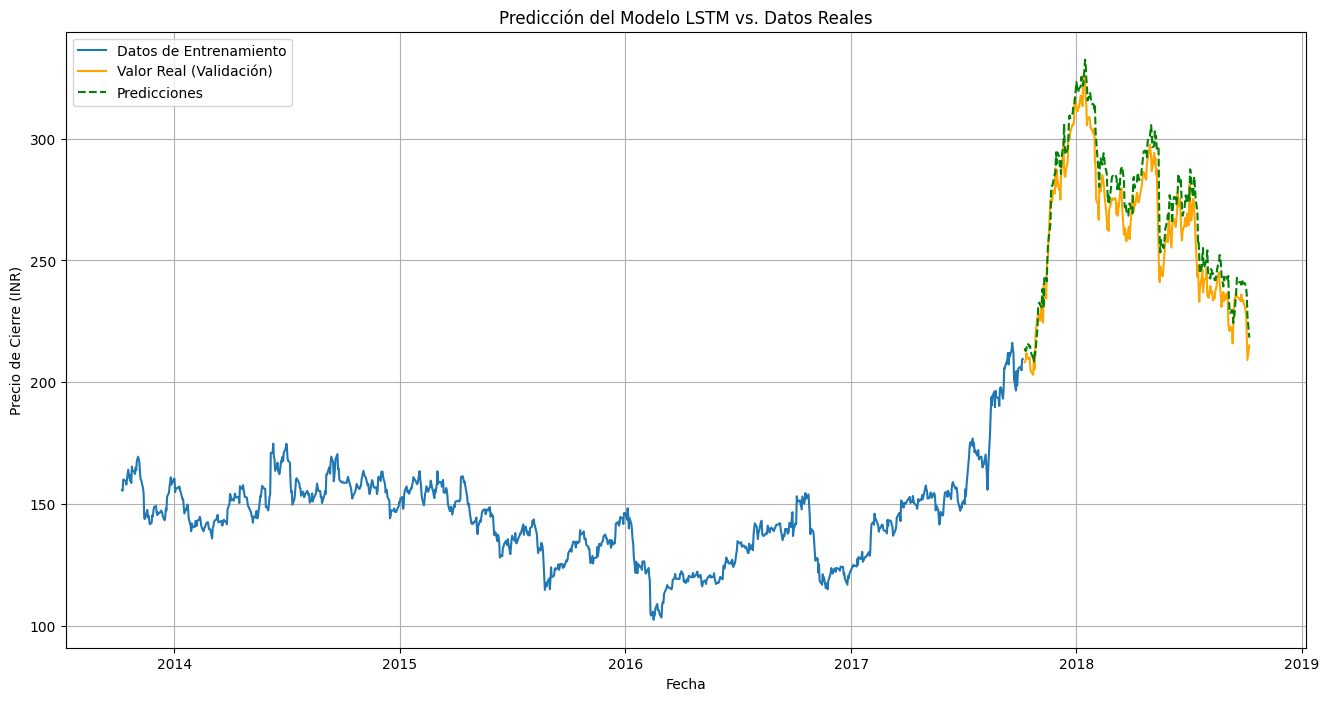

In [21]:
predicciones_escaladas = modelo_lstm.predict(X_prueba)

predicciones = escalador.inverse_transform(predicciones_escaladas)

rmse = np.sqrt(mean_squared_error(datos_validacion, predicciones))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f} INR')

entrenamiento = datos_cierre[:longitud_entrenamiento]
validacion = datos_cierre[longitud_entrenamiento:]
validacion['Predicciones'] = predicciones

plt.figure(figsize=(16, 8))
plt.title('Predicción del Modelo LSTM vs. Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (INR)')
plt.plot(entrenamiento['Close'], label='Datos de Entrenamiento')
plt.plot(validacion['Close'], label='Valor Real (Validación)', color='orange')
plt.plot(validacion['Predicciones'], label='Predicciones', color='green', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()